# Sporulation

In [1]:
from __future__ import print_function, division, absolute_import

import sys

import qminospy
from qminospy.me2 import ME_NLP
import os

# python imports
from copy import copy
import re
from os.path import join, dirname, abspath
import sys
sys.path.append('/home/UCSD/cobra_utils')
from collections import defaultdict
import pickle

# third party imports
import pandas
import cobra
from tqdm import tqdm
import numpy as np
import scipy

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import bacillusme
from bacillusme import (transcription, translation, flat_files, generics, formulas, compartments)
from cobrame.util.helper_functions import *

import copy
from scipy import stats
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
print(cobra.__file__)
print(cobrame.__file__)
print(bacillusme.__file__)
ecoli_files = dirname(abspath(bacillusme.__file__))
pd.set_option('display.max_colwidth', None)

/home/jt/me_modeling/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/home/jt/me_modeling/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


/home/jt/me_modeling/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/__init__.py
/home/jt/UCSD/cobrame/cobrame/__init__.py
/home/jt/UCSD/bacillusme-master/bacillusme/__init__.py


In [2]:
def add_transport_to_model(model,mets):
    for met in mets:
        rxn = cobrame.MEReaction('{}_transport'.format(met))
        model.add_reactions([rxn])
        rxn.add_metabolites({
            '{}_c'.format(met):-1,
            '{}_s'.format(met):1
        })
        rxn.bounds = (-1000,1000)
        print(rxn.reaction)

### Essentiality of FS genes

In [726]:
with open("./sporeme_solution_v4_proteomics_spoAQ_naive.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [430]:
add_transport_to_model(sporeme,['utp','ctp','gtp'])

utp_c <=> utp_s
ctp_c <=> ctp_s
gtp_c <=> gtp_s


In [431]:
from bacillusme.analysis import sensitivity as ss

In [432]:
genes = ['BSU' + g.id.split('RNA_BSU')[1] for g in sporeme.metabolites.query(re.compile('RNA_BSU.*_s$'))]

In [433]:
solve_me_model(sporeme,
                   max_mu = 0.1,
                   min_mu = .01,
                   using_soplex=False,
                   precision = 1e-6,
                   growth_key = 'sigma',
                   verbosity=2)

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 237.594292 seconds
Finished substituting S,lb,ub in 6.984262 seconds
Finished makeME_LP in 1.467879 seconds
Getting MINOS parameters from ME_NLP...
1 0.0 0.0 0.05 0.05 1
Finished substituting S,lb,ub in 6.936523 seconds
Finished makeME_LP in 1.304652 seconds
Getting MINOS parameters from ME_NLP...
2 0.025 0.025 0.05 0.025 optimal
Finished substituting S,lb,ub in 6.915431 seconds
Finished makeME_LP in 1.300308 seconds
Getting MINOS parameters from ME_NLP...
3 0.037500000000000006 0.037500000000000006 0.05 0.037500000000000006 optimal
Finished substituting S,lb,ub in 6.740821 seconds
Finished makeME_LP in 1.298511 seconds
Getting MINOS parameters from ME_NLP...
4 0.043750000000000004 0.043750000000000004 0.05 0.043750000000000004 optimal
Finished substituting S,lb,ub in 6.826514 seconds
Finished makeME_LP in 1.315644 seconds
Getting MINOS parameters from ME_NLP...
5 0.046875 0.046875 0.05 0.046875 optimal
Fin

In [ ]:
for i in range(0,int(len(genes)/100)+1):
    a,b = (i*100,i*100 + 100)
    b = min(b,len(genes))
    
    print(i+1,a,b)
    flux_responses = ss.all_flux_responses(sporeme,genes[a:b],NP=10,precision=1e-6, solution=sporeme.solution,
                       single_change_function='gene_knockout',growth_key='sigma')
    flux_responses.to_csv('essentiality_raw_results_naive_FS_transport_spoAQ_{}.csv'.format(i+1))

In [ ]:
flux_responses = {}
f = 'essentiality_raw_results_naive_FS_transport_spoAQ'
for i in tqdm(os.listdir()):
    if f not in i: continue
    if f+'.csv' == i: continue
    d = pd.read_csv(i,index_col=0).to_dict()
    for k,v in d.items():
        flux_responses[k] = v
flux_responses = pd.DataFrame.from_dict(flux_responses)
flux_responses.to_csv('{}.csv'.format(f))

In [ ]:
df = flux_responses.T
repeat = []
for i,row in df.drop('base').iterrows():
    f = row['translation_'+i]
    if  f>0.:
        repeat.append(i)
repeat

### Essentiality of MC genes

In [613]:
with open("./sporeme_solution_v4_proteomics_spoAQ_naive.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [614]:
from bacillusme.analysis import sensitivity as ss

In [ ]:
add_transport_to_model(sporeme,['utp','ctp','gtp'])

In [760]:
flux_based_reactions(sporeme,'BSU11220-MONOMER_mod_pydx5p_s',growth_symbol='sigma')

,lb,ub,rxn_flux,met_flux,reaction
ACOTA_FWD_BSU11220-MONOMER_mod_pydx5p_s,0,999999,0,-0,acorn_s + akg_s --> -7.29029234770651e-6*sigma BSU11220-MONOMER_mod_pydx5p_s + acg5sa_s + glu__L_s
formation_BSU11220-MONOMER_mod_pydx5p_s,0,1000,0,0,2.0 protein_BSU11220_s + pydx5p_s --> BSU11220-MONOMER_mod_pydx5p_s + 0.24411804099999998 prosthetic_group_biomass_s
ACOTA_REV_BSU11220-MONOMER_mod_pydx5p_s,0,999999,0,-0,acg5sa_s + glu__L_s --> -7.29029234770651e-6*sigma BSU11220-MONOMER_mod_pydx5p_s + acorn_s + akg_s


In [ ]:
genes = ['BSU' + g.id.split('RNA_BSU')[1] for \
         g in sporeme.metabolites.query(re.compile('RNA_BSU.*[^s]$'))]

In [ ]:
for i in range(0,int(len(genes)/100)+1):
    a,b = (i*100,i*100 + 100)
    b = min(b,len(genes))
    print(i+1,a,b)
    flux_responses = ss.all_flux_responses(sporeme,genes[a:b],NP=10,precision=1e-6, solution=sporeme.solution,
                       single_change_function='gene_knockout',growth_key='sigma')
    flux_responses.to_csv('essentiality_raw_results_naive_MC_transport_spoAQ_{}.csv'.format(i+1))

In [ ]:
flux_responses = {}
f = 'essentiality_raw_results_naive_MC_transport_spoAQ'
for i in tqdm(os.listdir()):
    if f not in i: continue
    if f+'.csv' == i: continue
    d = pd.read_csv(i,index_col=0).to_dict()
    for k,v in d.items():
        flux_responses[k] = v
flux_responses = pd.DataFrame.from_dict(flux_responses)
flux_responses.to_csv('{}.csv'.format(f))

In [ ]:
df = flux_responses.T
repeat = []
for i,row in df.drop('base').iterrows():
    f = row['translation_'+i]
    if  f>0.:
        repeat.append(i)
repeat

## Analysis
___

### Essentiality

In [436]:
with open("./sporeme_solution_v4_proteomics_spoAQ_naive.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [445]:
bsub = cobra.io.load_json_model(join(flat_files.ecoli_files_dir, 'iYO844.json'))

In [446]:
FS_df = pd.read_csv('essentiality_raw_results_naive_FS_transport_spoAQ.csv',index_col=0)
MC_df = pd.read_csv('essentiality_raw_results_naive_MC_transport_spoAQ.csv',index_col=0)
VG_df = pd.read_csv('../essentiality/essentiality_raw_me_results.csv',index_col=0)

In [447]:
# df = pd.read_csv('../essentiality/essentiality_raw_me_results_eco.csv',index_col=0)

In [448]:
def get_binary_essentiality(df,threshold = 1e-3,obj = 'biomass_dilution'):
    d = {}
    for g,row in df.T.iterrows():
        d[g.split('_s')[0]] = 1 if row[obj] < threshold else 0
    return d
def get_comparison(l,annotation=[],names=[]):
    d = {}
    for i in l[0]:
        if any(i not in di for di in l):
            continue
        v = [di[i] for di in l]
        if not names:
            names = range(len(l))
        d[i] = {ni:vi for ni,vi in zip(names,v)}
        if isinstance(annotation,pd.DataFrame):
            p = '{}-MONOMER'.format(i)
            if p in annotation.index:
                if i in bsub.genes:
                    model_annotation = [r.subsystem for r in bsub.genes.get_by_id(i).reactions]
                d[i]['annotation'] = annotation.loc[p]['name']
                d[i]['model_annotation'] = ','.join(model_annotation)
    return pd.DataFrame.from_dict(d).T

In [449]:
FS_es = get_binary_essentiality(FS_df,obj = 'biomass_dilution_s')
VG_es = get_binary_essentiality(VG_df,obj = 'biomass_dilution')
MC_es = get_binary_essentiality(MC_df,obj = 'biomass_dilution_s')
locus_to_name = pd.read_csv('../gene_name_dictionary.csv',index_col=0)['name'].to_dict()

In [450]:
# 
d = {}
for r in sporeme.reactions.query('^translation_BSU.*_s$'):
    g = r.id.split('translation_')[1].split('_s')[0]
    d[g] = {
        'name' : locus_to_name[g],
        'FS_flux' : sporeme.solution.x_dict['translation_{}_s'.format(g)],
        'FS_essential' : bool(FS_es[g]),
        'MC_flux' : sporeme.solution.x_dict['translation_{}'.format(g)],
        'MC_essential' : bool(MC_es[g])
    }
summary_df = pd.DataFrame.from_dict(d).T
summary_df.to_csv('essentiality_summary_naive_spoAQ.csv')
summary_df[(summary_df['FS_flux'] > 1e-16)].to_csv('FS_proteins_summary_spoAQ.csv')
summary_df[(summary_df['MC_flux'] > 1e-16)].to_csv('MC_proteins_summary_spoAQ.csv')
summary_df.head()

,name,FS_flux,FS_essential,MC_flux,MC_essential
BSU00090,guaB,0,False,8.94486e-09,False
BSU00110,pdxS,0,False,0,False
BSU00120,pdxT,0,False,0,False
BSU00130,serS,6.69977e-10,True,2.56869e-09,True
BSU00140,dck,1.56101e-09,False,0,False


In [451]:
complexes = pd.read_csv('bacillus_complexes.csv',index_col=0)

In [452]:
c = get_comparison([FS_es,MC_es,VG_es],annotation=complexes,names=['FS','MC','VG'])

FS    170.0
MC    182.0
VG    301.0
dtype: float64


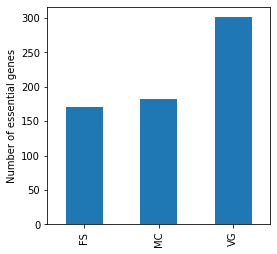

In [453]:
print(c[['FS','MC','VG']].sum())
c[['FS','MC','VG']].sum().plot.bar(figsize=(4,4))
plt.ylabel('Number of essential genes')
plt.savefig('./figures/essential_genes_naive_spoAQ.svg',format='SVG')

In [454]:
from matplotlib_venn import venn3
plt.rcParams['svg.fonttype'] = 'none'

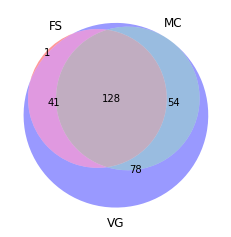

In [455]:
fs = set(c[c['FS']>0].index)
mc = set(c[c['MC']>0].index)
vg = set(c[c['VG']>0].index)
venn3([fs,mc,vg],('FS','MC','VG'))
plt.savefig('figures/venn_FS_MC_VG_naive_spoAQ.svg',format='SVG')

### Comparison

In [457]:
import pandas as pd
import numpy as np
df_base = pd.read_csv('essentiality_raw_results_FS_spoAQ.csv',index_col=0)
df_ntp = pd.read_csv('essentiality_raw_results_naive_FS_transport_spoAQ.csv',index_col=0)

In [458]:
df = pd.DataFrame([df_base['base'],df_ntp.rename({'base':'ntp'},axis=1)['ntp']]).T
df = df[df.index.str.contains('_s$')]
df.head()

,base,ntp
biomass_dilution_s,0.041170,0.049123
protein_biomass_to_biomass_s,0.002425,0.003117
mRNA_biomass_to_biomass_s,0.000007,0.000009
tRNA_biomass_to_biomass_s,0.000043,0.000055
rRNA_biomass_to_biomass_s,0.000312,0.000407


<AxesSubplot:>

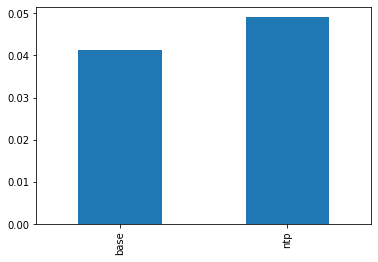

In [459]:
df.loc['biomass_dilution_s'].plot.bar()

<AxesSubplot:>

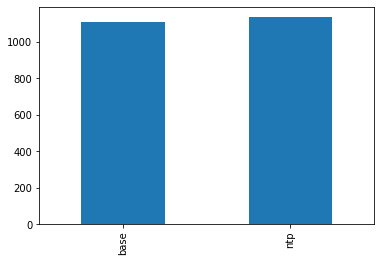

In [460]:
df.abs().gt(0).sum().plot.bar()

### Gene interdependence

In [661]:
with open("./sporeme_solution_v4_proteomics_spoAQ_naive.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [662]:
locus_to_name = pd.read_csv('../gene_name_dictionary.csv',index_col=0)['name'].to_dict()
name_to_locus = pd.read_csv('../gene_name_dictionary.csv',index_col=1)['locus_id'].to_dict()

In [742]:
import pandas as pd
df = pd.read_csv('essentiality_raw_results_naive_FS_transport_spoAQ.csv',index_col=0).T
VG_df = pd.read_csv('../essentiality/essentiality_raw_me_results.csv',index_col=0).T

In [687]:
cutoff = 1e-20 # Tolerance for any flux
growth_cutoff = df['biomass_dilution']['base'] * 0.1 # 10% or lower growth rate = no growth
translation = df[df['biomass_dilution']>growth_cutoff][[i for i in df.columns if re.search('translation_.*_s',i)]].T
active_base = translation[translation['base']>cutoff].T.drop('base')
inactive_base = translation[translation['base']<=cutoff].T.drop('base')

In [688]:
df[(df['biomass_dilution']>0) & (df['biomass_dilution']<growth_cutoff)]

,biomass_dilution,protein_biomass_to_biomass,mRNA_biomass_to_biomass,tRNA_biomass_to_biomass,rRNA_biomass_to_biomass,ncRNA_biomass_to_biomass,DNA_biomass_to_biomass,lipid_biomass_to_biomass,constituent_biomass_to_biomass,prosthetic_group_biomass_to_biomass,...,Demand_pgly_BS_s,Demand_psetha_BS_s,Demand_t12dg_BS_s,Demand_gtca3_45_BS_s,Demand_lipo1_24_BS_s,Demand_tcam_BS_s,formation_combined_PORE-CPLX_s,utp_transport,ctp_transport,gtp_transport
BSU25640_s,0.000161,0.000095,2.485370e-07,0.000001,0.000011,5.213883e-11,0.0,0.000000e+00,0.0,6.966712e-08,...,0.000123,0.000123,0.000123,0.000123,0.011876,0.000123,1.306236e-08,-0.739400,4.881244,0.002471
BSU25290_s,0.000440,0.000260,6.755680e-07,0.000004,0.000030,6.478568e-12,0.0,-2.208976e-56,0.0,1.723825e-07,...,0.000049,0.000049,0.000049,0.000049,0.000049,0.000049,4.100586e-09,0.078347,2.615570,1.350933


In [689]:
essential_genes = list(df[df['biomass_dilution']<growth_cutoff].index)
VG_essential_genes = list(VG_df[VG_df['biomass_dilution']<growth_cutoff].index)
active_genes = [g.split('translation_')[1].split('_s')[0] for g in active_base.columns]

In [690]:
id_dep = defaultdict(list)
name_dep = defaultdict(list)
fwd_id_dep = defaultdict(list)
fwd_name_dep = defaultdict(list)
for g,row in active_base.iterrows():
    g = g.split('_s')[0]
    gname = locus_to_name[g]
    for i,_ in row[row<cutoff].items():
        gene = i.split('translation_')[1].split('_s')[0]
        gene_name = locus_to_name[gene]
        
        id_dep[gene].append(g)
        name_dep[gene_name].append(gname)
        
        fwd_id_dep[g].append(gene)
        fwd_name_dep[gname].append(gene_name)
        

### Known depletions

In [691]:
known_depletions = [g[0].lower() + g[1:] for g in list(pd.read_csv('proteomics/known_depletions.txt')['protein'].values)]
confirmed_depletions = ['pckA','purL','ilvB','ilvE','citZ','acsA','etfA','acoC','sigF','yxbC','lutC',
                  'argJ','hpf']

In [692]:
res = {}
for g in known_depletions:
    locus = name_to_locus[g]
    dep_genes = [i for i in id_dep[locus]]
    res[g] = {
        'locus_id':locus,
        'in_model':'RNA_'+locus in sporeme.metabolites,
        'FS_essential':locus+'_s' in essential_genes,
        'VG_essential':locus in VG_essential_genes,
        'active':locus in active_genes,
        'depends on':', '.join([locus_to_name[i] if i in locus_to_name else i for i in dep_genes])
    }

In [693]:
res_df = pd.DataFrame.from_dict(res).T.sort_index()

In [694]:
res_df.to_csv('proteomics/dependence_results_transport_spoAQ.csv')

In [695]:
res_df.sort_values('depends on',ascending=False).head(20)

,locus_id,in_model,FS_essential,VG_essential,active,depends on
sucC,BSU16090,True,False,False,True,"sucC, sucD, hprT, deoB, scoB, scoA, gmk, yfkN, sigE, tpiA, pgk, gapA, prs, adk"
sucD,BSU16100,True,False,False,True,"sucC, sucD, hprT, deoB, scoB, scoA, gmk, yfkN, sigE, tpiA, pgk, gapA, prs, adk"
sigE,BSU15320,True,False,True,True,sigE
nadC,BSU27860,True,False,True,True,"ribC, nadA, nadB, nadC, sufU"
mdh,BSU29120,True,False,False,True,"mdh, fumC, pgk, gapA"
ilvC,BSU28290,True,False,True,True,"ilvD, ilvC, bcd, rpiB, sufU, gndA"
fadN,BSU32840,True,False,False,True,"fadA, fadN"
citB,BSU18000,True,False,False,True,"citB, sufU"
acdA,BSU37170,True,False,False,True,"acdA, fadA, fadN"
yfmG,BSU07480,False,False,False,False,


### Essential in FS

sigB is essential because it regulates synthesis of teichoic acid for biomass component tcam_BS_c. BsubCyc shows it is not essential but the model requires it for cell wall synthesis.

In [696]:
res_df[res_df['FS_essential']>0]

,locus_id,in_model,FS_essential,VG_essential,active,depends on
sigB,BSU04730,True,True,True,True,
sigF,BSU23450,True,True,False,True,


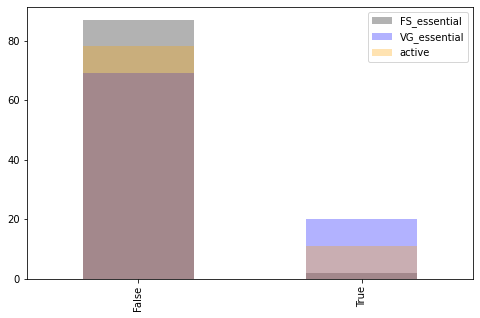

In [697]:
# None of them are essential
fig, ax = plt.subplots(figsize=(8,5))
res_df['FS_essential'].value_counts().plot.bar(ax=ax,color='k',alpha=0.3)
res_df['VG_essential'].value_counts().plot.bar(ax=ax,color='b',alpha=0.3)
res_df['active'].value_counts().plot.bar(ax=ax,color='orange',alpha=0.3)
plt.legend()
plt.savefig('./figures/gene_interdependence_stats_transport_spoAQ.svg',format='SVG')

In [698]:
res_df['active'].value_counts()

False    78
True     11
Name: active, dtype: int64

In [699]:
res_df[res_df['active']==True]

,locus_id,in_model,FS_essential,VG_essential,active,depends on
acdA,BSU37170,True,False,False,True,"acdA, fadA, fadN"
citB,BSU18000,True,False,False,True,"citB, sufU"
fadN,BSU32840,True,False,False,True,"fadA, fadN"
ilvC,BSU28290,True,False,True,True,"ilvD, ilvC, bcd, rpiB, sufU, gndA"
mdh,BSU29120,True,False,False,True,"mdh, fumC, pgk, gapA"
nadC,BSU27860,True,False,True,True,"ribC, nadA, nadB, nadC, sufU"
sigB,BSU04730,True,True,True,True,
sigE,BSU15320,True,False,True,True,sigE
sigF,BSU23450,True,True,False,True,
sucC,BSU16090,True,False,False,True,"sucC, sucD, hprT, deoB, scoB, scoA, gmk, yfkN, sigE, tpiA, pgk, gapA, prs, adk"


In [700]:
res_df.loc[confirmed_depletions]

,locus_id,in_model,FS_essential,VG_essential,active,depends on
pckA,BSU30560,True,False,False,False,
purL,BSU06480,True,False,False,False,
ilvB,BSU28310,True,False,False,False,
ilvE,BSU02390,True,False,False,False,
citZ,BSU29140,True,False,False,False,
acsA,BSU29680,True,False,False,False,
etfA,BSU28520,False,False,False,False,
acoC,BSU08080,False,False,False,False,
sigF,BSU23450,True,True,False,True,
yxbC,BSU39880,False,False,False,False,


13


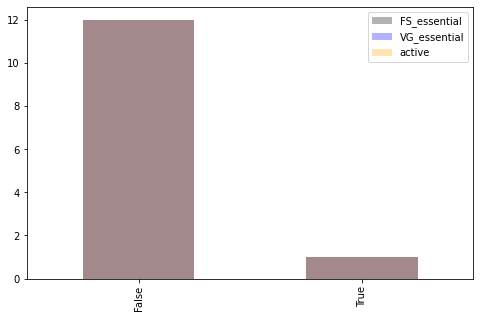

In [701]:
print(len(confirmed_depletions))
# None of them are essential
fig, ax = plt.subplots(figsize=(8,5))
res_df.loc[confirmed_depletions]['FS_essential'].value_counts().plot.bar(ax=ax,color='k',alpha=0.3)
res_df.loc[confirmed_depletions]['VG_essential'].value_counts().plot.bar(ax=ax,color='b',alpha=0.3)
res_df.loc[confirmed_depletions]['active'].value_counts().plot.bar(ax=ax,color='orange',alpha=0.3)
plt.legend()
plt.savefig('./figures/confirmed_gene_interdependence_stats_transport.svg',format='SVG')

In [702]:
df = res_df.loc[confirmed_depletions]
df[df['in_model']==False].shape[0]

5

In [703]:
res_df[res_df['in_model']==False].shape[0]

30

In [704]:
res_df.shape

(89, 6)

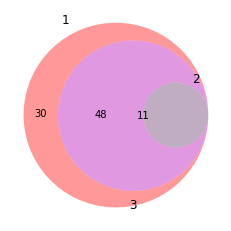

In [705]:
from matplotlib_venn import venn2,venn3
df = res_df
plt.rcParams['svg.fonttype'] = 'none'
df1 = set(df.index)
df2 = set(df[df['active']==True].index)
df3 = set(df[df['in_model']==True].index)
venn3([df1,df2,df3],('1','2','3'))
plt.savefig('./figures/venn_essential_active_model_known_spoAQ.svg',format='SVG')

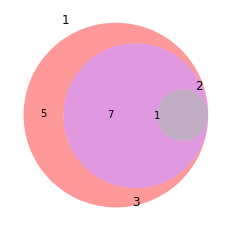

In [706]:
from matplotlib_venn import venn2,venn3
df = res_df.loc[confirmed_depletions]
plt.rcParams['svg.fonttype'] = 'none'
df1 = set(df.index)
df2 = set(df[df['active']==True].index)
df3 = set(df[df['in_model']==True].index)
venn3([df1,df2,df3],('1','2','3'))
plt.savefig('./figures/venn_essential_active_model_confirmed_spoAQ.svg',format='SVG')

## Backward interdependence

In [707]:
# importing networkx
import networkx as nx
# importing matplotlib.pyplot
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
G = nx.DiGraph()

for i in res_df[res_df['in_model']==True].index:
    dep_genes = name_dep[i]
    for j in dep_genes:
        if j==i: continue
        G.add_edge(j,i)

In [584]:
color_map = []
for node in G:
    if node in confirmed_depletions:
        color_map.append('green')
    elif node in res_df.index:
        color_map.append('blue')
    else: 
        color_map.append('gray')      

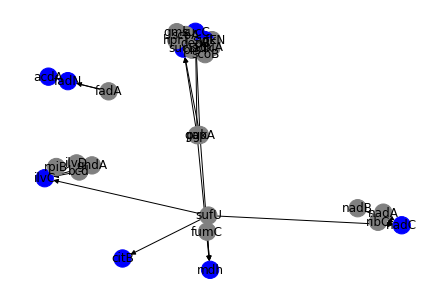

In [585]:
# plt.figure(figsize=(8,8))
pos = nx.spring_layout(G, k=2.)
nx.draw(G,
#        pos=pos,
       with_labels = True,
#        node_size=2000,
#        arrowsize=20,
#        width = 1.5,
#        font_size=15,
       node_color=color_map
       )
# plt.savefig('./figures/network_gene_interdependence_spring_transport.svg',format='SVG')

## Forward interdependence

In [586]:
# importing networkx
import networkx as nx
# importing matplotlib.pyplot
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
G = nx.DiGraph()

for i in res_df[res_df['in_model']==True].index:
    dep_genes = fwd_name_dep[i]
    for j in dep_genes:
        if j==i: continue
        G.add_edge(i,j)

In [587]:
color_map = []
for node in G:
    if node in confirmed_depletions:
        color_map.append('green')
    elif node in res_df.index:
        color_map.append('blue')
    else: 
        color_map.append('gray')      

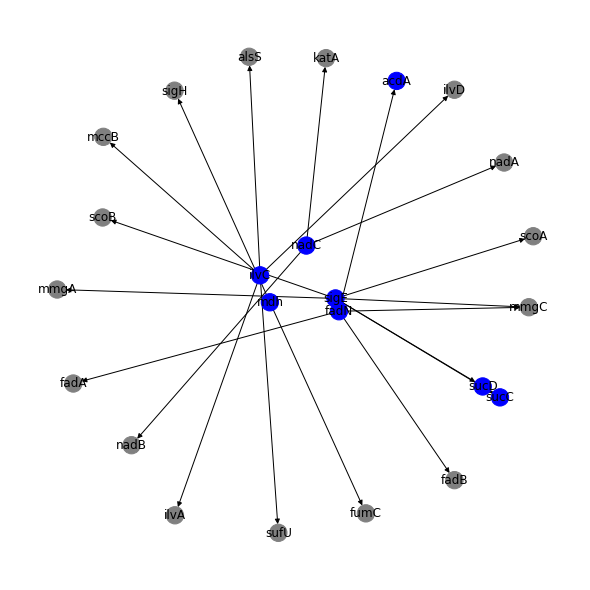

In [588]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(G, k=2.)
nx.draw(G,
#        pos=pos,
       with_labels = True,
#        node_size=2000,
#        arrowsize=20,
#        width = 1.5,
#        font_size=15,
       node_color=color_map
       )
# plt.savefig('./figures/network_gene_interdependence_spring_fwd_transport.svg',format='SVG')

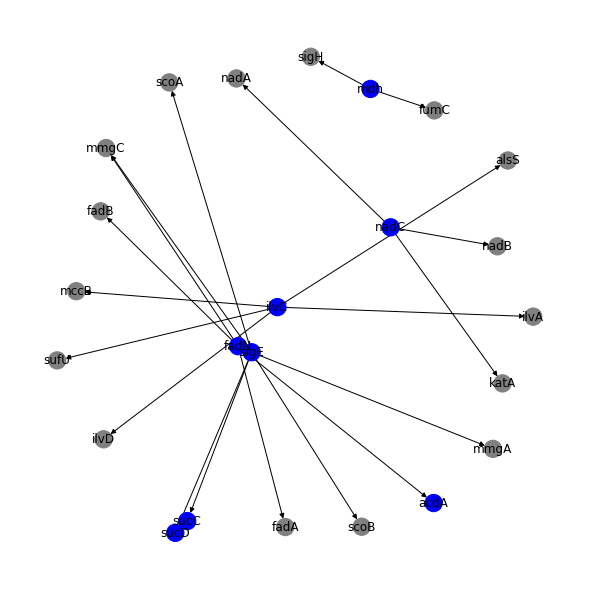

In [589]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(G, k=2.)
nx.draw(G,
#        pos=pos,
       with_labels = True,
#        node_size=2000,
#        arrowsize=20,
#        width = 1.5,
#        font_size=15,
       node_color=color_map
       )
# plt.savefig('./figures/network_gene_interdependence_spring_fwd_transport.svg',format='SVG')

## FWD and BWD interdependence

In [590]:
# importing networkx
import networkx as nx
# importing matplotlib.pyplot
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
G = nx.DiGraph()

for i in res_df[res_df['in_model']==True].index:
    dep_genes = name_dep[i]
    for j in dep_genes:
        if j==i: continue
        G.add_edge(j,i)

for i in res_df[res_df['in_model']==True].index:
    dep_genes = fwd_name_dep[i]
    for j in dep_genes:
        if j==i: continue
        G.add_edge(i,j)

In [591]:
color_map = []
degree = []
labels = {}
for node in G:
    d = len(fwd_id_dep[node])
    degree.append(d)
    name = locus_to_name[node] if node in locus_to_name else node
    if name in confirmed_depletions:
        color_map.append('green')
    elif name in res_df.index:
        color_map.append('blue')
    else: 
        color_map.append('gray')
    if d > 5:
        labels[node] = locus_to_name[node] if node in locus_to_name else node

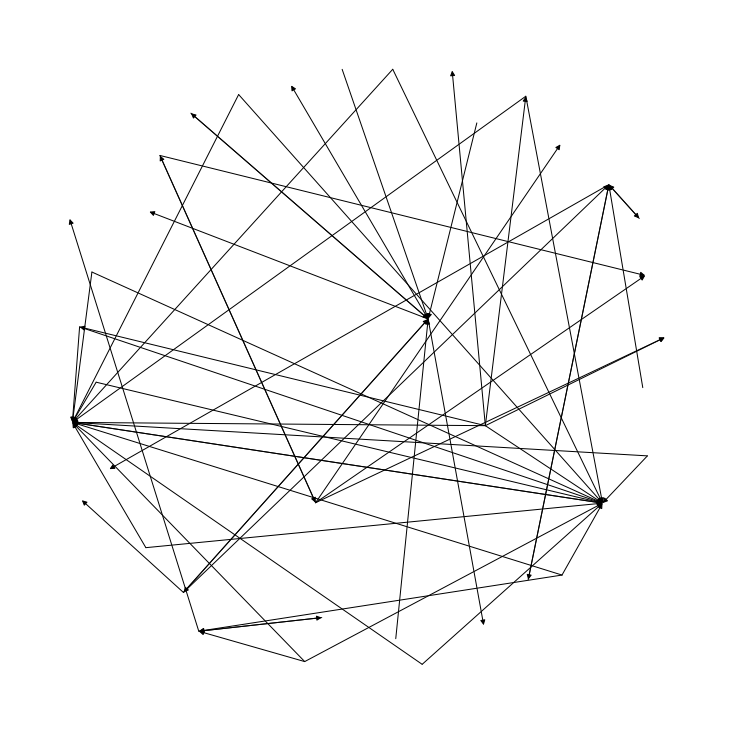

In [592]:
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G, k=2.)
nx.draw(G,
       pos=pos,
       node_color=color_map,
       node_size=[i*50 for i in degree])
_ = nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='k')
# plt.savefig('./figures/network_gene_interdependence_spring_fwd_genome.svg',format='SVG')

In [593]:
color_map = []
for node in G:
    if node in confirmed_depletions:
        color_map.append('green')
    elif node in res_df.index:
        color_map.append('blue')
    else: 
        color_map.append('gray')      

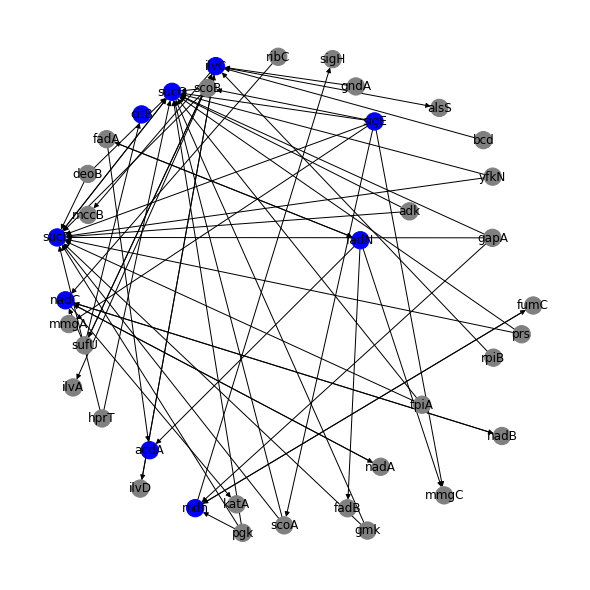

In [594]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(G, k=2.)
nx.draw(G,
       pos=pos,
       with_labels = True,
#        node_size=2000,
#        arrowsize=20,
#        width = 1.5,
#        font_size=15,
       node_color=color_map)
# plt.savefig('./figures/network_gene_interdependence_spring_fwd_bwd.svg',format='SVG')

## Subgraphs

In [595]:
def get_color_map(G):
    color_map = []
    degree = []
    labels = {}
    for node in G:
        d = len(fwd_name_dep[node])
        degree.append(d)
        name = locus_to_name[node] if node in locus_to_name else node
        if name in confirmed_depletions:
            color_map.append('green')
        elif name in known_depletions:
            color_map.append('blue')
        else: 
            color_map.append('gray')
    #     if d > 5:
        labels[node] = locus_to_name[node] if node in locus_to_name else node
    return color_map,degree,labels

subgraph 0 has 23 nodes
	Nodes: {'scoA', 'sigH', 'prs', 'fadA', 'hprT', 'sucC', 'scoB', 'adk', 'yfkN', 'mdh', 'fumC', 'sucD', 'mmgA', 'fadN', 'gmk', 'deoB', 'pgk', 'gapA', 'mmgC', 'fadB', 'sigE', 'acdA', 'tpiA'}
subgraph 1 has 15 nodes
	Nodes: {'ilvA', 'alsS', 'nadB', 'katA', 'ribC', 'nadA', 'citB', 'gndA', 'mccB', 'sufU', 'bcd', 'rpiB', 'ilvC', 'ilvD', 'nadC'}


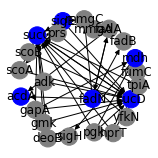

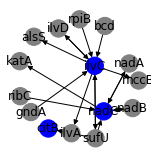

In [596]:
UG = G.to_undirected()
# extract subgraphs
sub_graphs = nx.connected_components(UG)

for i, sg in enumerate(sub_graphs):
    if not set(known_depletions) & sg: continue
    print ("subgraph {} has {} nodes".format(i, len(sg)))
    print ("\tNodes:", sg)
    SG = G.subgraph(sg)
    color_map,degree,labels = get_color_map(SG)
    if len(SG.nodes) > 4:
        plt.figure(figsize=(2,2))
    else:
        plt.figure(figsize=(1,1))
        
        
    pos = nx.spring_layout(SG, k=2.0)
    nx.draw(SG,
           pos=pos,
           with_labels = True,
    #        node_size=[i*50 for i in degree],
    #        arrowsize=20,
    #        width = 1.5,
    #        font_size=15,
           node_color=color_map
           )
#     plt.savefig('figures/network_sg_{}_spoAQ.svg'.format(i),format='SVG')

## Genome-scale interdependence

In [708]:
# importing networkx
import networkx as nx
# importing matplotlib.pyplot
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
G = nx.DiGraph()

for i in sporeme.genes:
    i = i.id
    dep_genes = fwd_id_dep[i]
#     if len(dep_genes) < 30: continue
    for j in dep_genes:
        if j==i: continue
        G.add_edge(i,j)
print(len(G.edges))

172


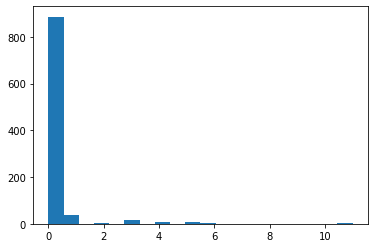

In [709]:
_=plt.hist([len(fwd_id_dep[i]) for i in fwd_id_dep],bins=20)

In [710]:
color_map = []
degree = []
labels = {}
for node in G:
    d = len(fwd_id_dep[node])
    degree.append(d)
    name = locus_to_name[node] if node in locus_to_name else node
    if name in confirmed_depletions:
        color_map.append('green')
    elif name in res_df.index:
        color_map.append('blue')
    else: 
        color_map.append('gray')
    if d > 5:
        labels[node] = locus_to_name[node] if node in locus_to_name else node

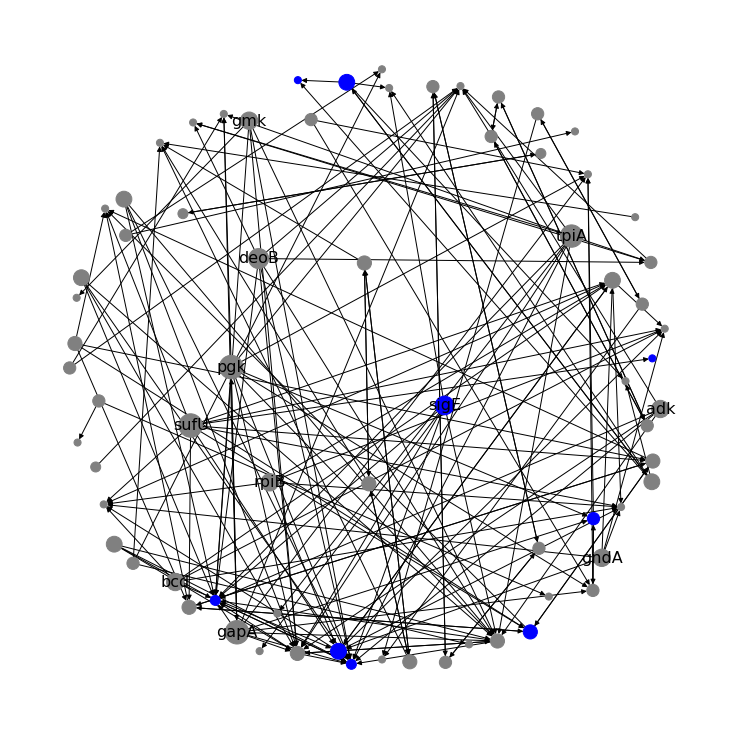

In [711]:
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G, k=2.)
nx.draw(G,
       pos=pos,
       node_color=color_map,
       node_size=[i*50 for i in degree])
_ = nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='k')
# plt.savefig('./figures/network_gene_interdependence_spring_fwd_genome.svg',format='SVG')

## One gene interdependence

In [712]:
def get_edges_from_gene(gene):
    edges = set()
    for j in fwd_name_dep[gene]:
        if j==gene: continue
        edges.add((gene,j))
    for j in name_dep[gene]:
        if j==gene: continue
        edges.add((j,gene))
    return edges

def get_graph_from_gene(gene):
    import networkx as nx
    import matplotlib.pyplot as plt
    plt.rcParams['svg.fonttype'] = 'none'
    G = nx.DiGraph()
    edges = get_edges_from_gene(gene)
    for i,j in edges:
        G.add_edge(i,j)
    return G

In [713]:
G = get_graph_from_gene('ilvC')

In [714]:
color_map = []
degree = []
labels = {}
for node in G:
    d = len(fwd_name_dep[node])
    degree.append(d)
    name = locus_to_name[node] if node in locus_to_name else node
    if name in confirmed_depletions:
        color_map.append('green')
    elif name in res_df.index:
        color_map.append('blue')
    else: 
        color_map.append('gray')
#     if d > 5:
    labels[node] = locus_to_name[node] if node in locus_to_name else node

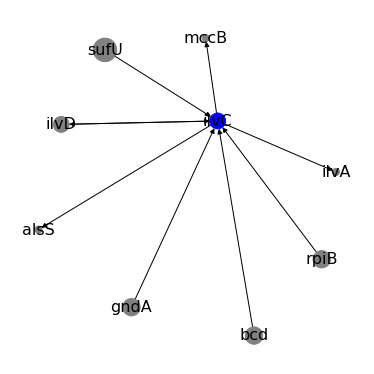

In [715]:
plt.figure(figsize=(5,5))
pos = nx.spring_layout(G, k=2.)
nx.draw(G,
       pos=pos,
       node_color=color_map,
       node_size=[i*50 for i in degree])
_ = nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='k')
plt.savefig('./figures/network_gene_interdependence_spring_fwd_{}_spoAQ.svg'.format(gene),format='SVG')

## Known depletions neighborhood

In [716]:
# importing networkx
import networkx as nx
# importing matplotlib.pyplot
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
G = nx.DiGraph()
edges = set()
for j in known_depletions:
    e = get_edges_from_gene(j)
    edges = edges | e
for i,j in edges:
    G.add_edge(i,j)

In [717]:
color_map = []
degree = []
labels = {}
for node in G:
    d = len(fwd_name_dep[node])
    degree.append(d)
    name = locus_to_name[node] if node in locus_to_name else node
    if name in confirmed_depletions:
        color_map.append('green')
    elif name in res_df.index:
        color_map.append('blue')
    else: 
        color_map.append('gray')
#     if d > 5:
    labels[node] = locus_to_name[node] if node in locus_to_name else node

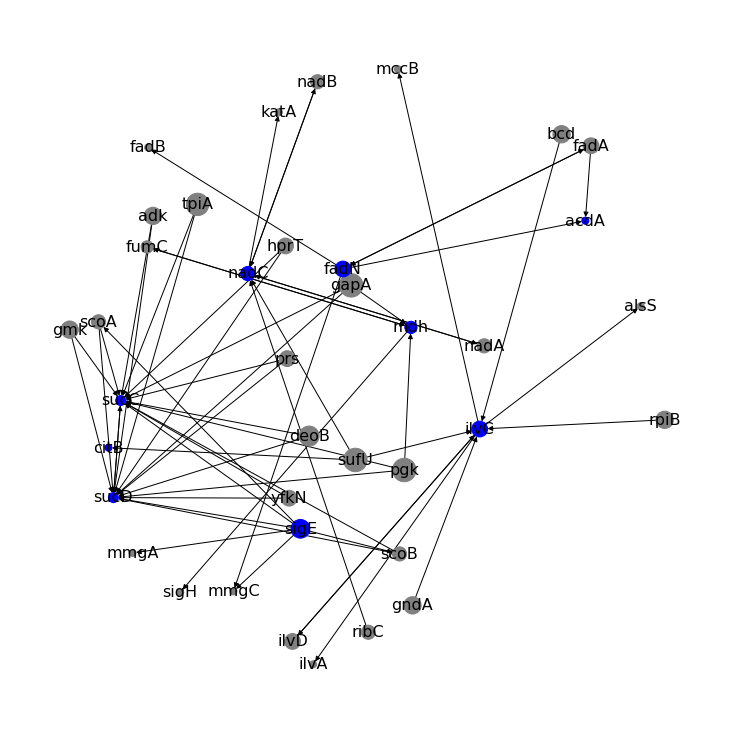

In [718]:
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G, k=1.)
nx.draw(G,
       pos=pos,
       node_color=color_map,
       node_size=[i*50 for i in degree])
_ = nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='k')
# plt.savefig('./figures/network_gene_interdependence_spring_fwd_genome.svg',format='SVG')

In [719]:
import json
d =nx.cytoscape_data(G)
with open('inactive_network.json','w') as f:
    json.dump(d,f)

In [720]:
len(G.nodes)

38

In [721]:
pd.DataFrame.from_dict({'locus':{i:name_to_locus[i] for i in G.nodes}}).to_csv('confirmed_depletion_neighborhood_spoAQ.txt',header=None)

In [ ]:
i = name_to_locus['nadD']
j = name_to_locus['acdA']
translation.loc['translation_{}_s'.format(j)]['{}_s'.format(i)]

## Subgraphs

In [723]:
def get_edges_from_gene(gene):
    edges = set()
    for j in fwd_name_dep[gene]:
        if j==gene: continue
        edges.add((gene,j))
    for j in name_dep[gene]:
        if j==gene: continue
        edges.add((j,gene))
    return edges

def get_graph_from_gene(gene):
    import networkx as nx
    import matplotlib.pyplot as plt
    plt.rcParams['svg.fonttype'] = 'none'
    G = nx.DiGraph()
    edges = get_edges_from_gene(gene)
    for i,j in edges:
        G.add_edge(i,j)
    return G

In [724]:
def get_color_map(G):
    color_map = []
    degree = []
    labels = {}
    for node in G:
        d = len(fwd_name_dep[node])
        degree.append(d)
        name = locus_to_name[node] if node in locus_to_name else node
        if name in confirmed_depletions:
            color_map.append('green')
        elif name in known_depletions:
            color_map.append('blue')
        else: 
            color_map.append('gray')
    #     if d > 5:
        labels[node] = locus_to_name[node] if node in locus_to_name else node
    return color_map,degree,labels

subgraph 0 has 14 nodes
	Nodes: ['sigE', 'sucC', 'tpiA', 'prs', 'gmk', 'yfkN', 'adk', 'scoB', 'gapA', 'pgk', 'hprT', 'sucD', 'deoB', 'scoA']
subgraph 1 has 3 nodes
	Nodes: ['fadN', 'acdA', 'fadA']
subgraph 2 has 2 nodes
	Nodes: ['sufU', 'citB']
subgraph 3 has 5 nodes
	Nodes: ['mdh', 'sigH', 'pgk', 'fumC', 'gapA']
subgraph 4 has 14 nodes
	Nodes: ['scoB', 'sucD', 'gapA', 'hprT', 'deoB', 'scoA', 'pgk', 'adk', 'sucC', 'sigE', 'tpiA', 'prs', 'gmk', 'yfkN']
subgraph 5 has 7 nodes
	Nodes: ['sigE', 'mmgC', 'sucC', 'scoB', 'mmgA', 'sucD', 'scoA']
subgraph 6 has 5 nodes
	Nodes: ['fadA', 'fadN', 'fadB', 'acdA', 'mmgC']
subgraph 7 has 9 nodes
	Nodes: ['ilvD', 'ilvC', 'bcd', 'mccB', 'ilvA', 'rpiB', 'sufU', 'alsS', 'gndA']
subgraph 8 has 6 nodes
	Nodes: ['nadC', 'katA', 'nadA', 'ribC', 'sufU', 'nadB']


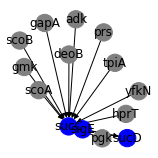

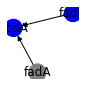

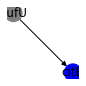

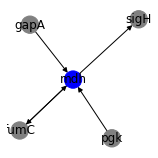

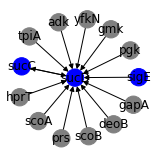

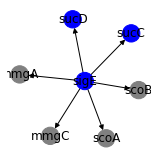

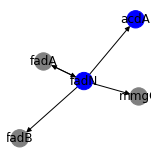

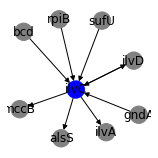

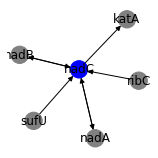

In [725]:
for i, gene in enumerate(set(known_depletions) & set(G.nodes)):
    SG = get_graph_from_gene(gene)
    print ("subgraph {} has {} nodes".format(i, len(SG.nodes)))
    print ("\tNodes:", SG.nodes)
    
    color_map,degree,labels = get_color_map(SG)
    if len(SG.nodes) > 4:
        plt.figure(figsize=(2,2))
    else:
        plt.figure(figsize=(1,1))
        
        
    pos = nx.spring_layout(SG, k=1.0)
    nx.draw(SG,
           pos=pos,
           with_labels = True,
    #        node_size=[i*50 for i in degree],
    #        arrowsize=20,
    #        width = 1.5,
    #        font_size=15,
           node_color=color_map
           )
    plt.savefig('figures/network_sg_{}_spoAQ.svg'.format(i),format='SVG')

## Histogram

In [358]:
d = {k:len(v) for k,v in fwd_name_dep.items()}

In [359]:
df = pd.DataFrame.from_dict({'influence':d})

<AxesSubplot:ylabel='Frequency'>

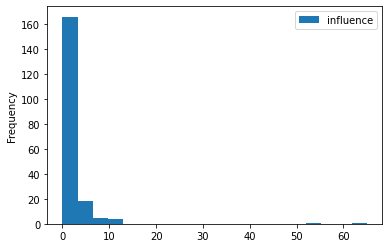

In [360]:
df.plot.hist(bins = 20)

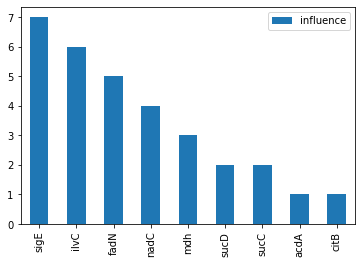

In [369]:
df1 = df.loc[[i for i in known_depletions if i in df.index]].sort_values('influence',ascending=False)
df1[df1['influence'] > 0].plot.bar()
plt.savefig('bar_inactivated.svg',format='SVG')

## Heatmap

In [314]:
locus_to_name = pd.read_csv('../gene_name_dictionary.csv',index_col=0)['name'].to_dict()
name_to_locus = pd.read_csv('../gene_name_dictionary.csv',index_col=1)['locus_id'].to_dict()

In [315]:
known_depletions = [g[0].lower() + g[1:] for g in list(pd.read_csv('proteomics/known_depletions.txt')['protein'].values)]

In [316]:
import pandas as pd
df = pd.read_csv('essentiality_raw_results_naive_FS_transport_spoAQ.csv',index_col=0).T
translation = df[[i for i in df.columns if re.search('translation_.*_s',i)]].T
translation = translation[translation['base']>cutoff].T

In [317]:
from tqdm import tqdm
import seaborn as sns
from scipy.stats import zscore

In [318]:
expression = {}
for i,row in tqdm(translation.iterrows(),total=translation.shape[0]):
    i = i.split('_s')[0]
    iname = locus_to_name[i] if i in locus_to_name else i
    expression[iname] = {}
    for j,val in row.items():
        j = j.split('translation_')[1].split('_s')[0]
        jname = locus_to_name[j] if j in locus_to_name else j
        expression[iname][jname] = val
expression = pd.DataFrame.from_dict(expression).drop('dummy')

100%|██████████| 733/733 [00:00<00:00, 1419.58it/s]


In [319]:
depletions_in_model = [i for i in known_depletions if i in expression.index]

In [320]:
log_expression_all = np.log10(expression[depletions_in_model + ['base']]+1e-16)
log_expression_known = np.log10(expression.loc[depletions_in_model][depletions_in_model + ['base']]+1e-16)

<AxesSubplot:>

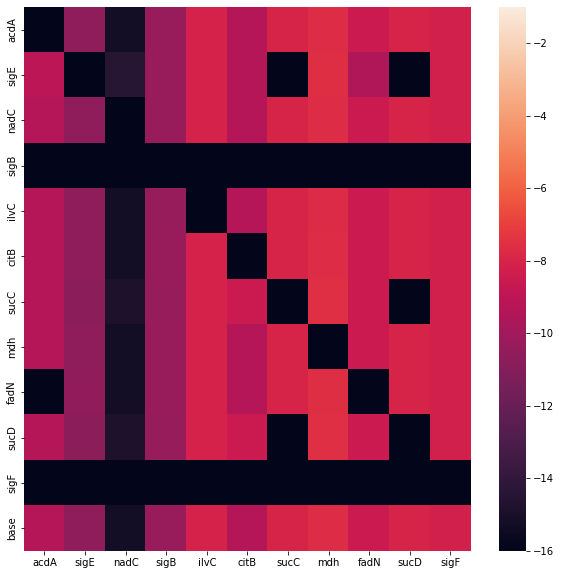

In [321]:
plt.figure(figsize=(10,10))
sns.heatmap(log_expression_known.T,
           vmin = -1,
           vmax = -16)

<AxesSubplot:>

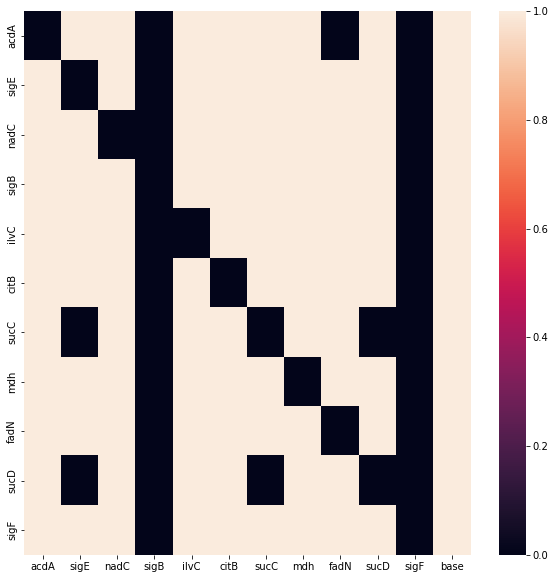

In [326]:
plt.figure(figsize=(10,10))
sns.heatmap((expression>0.).loc[depletions_in_model][depletions_in_model + ['base']])


<Figure size 1440x720 with 0 Axes>

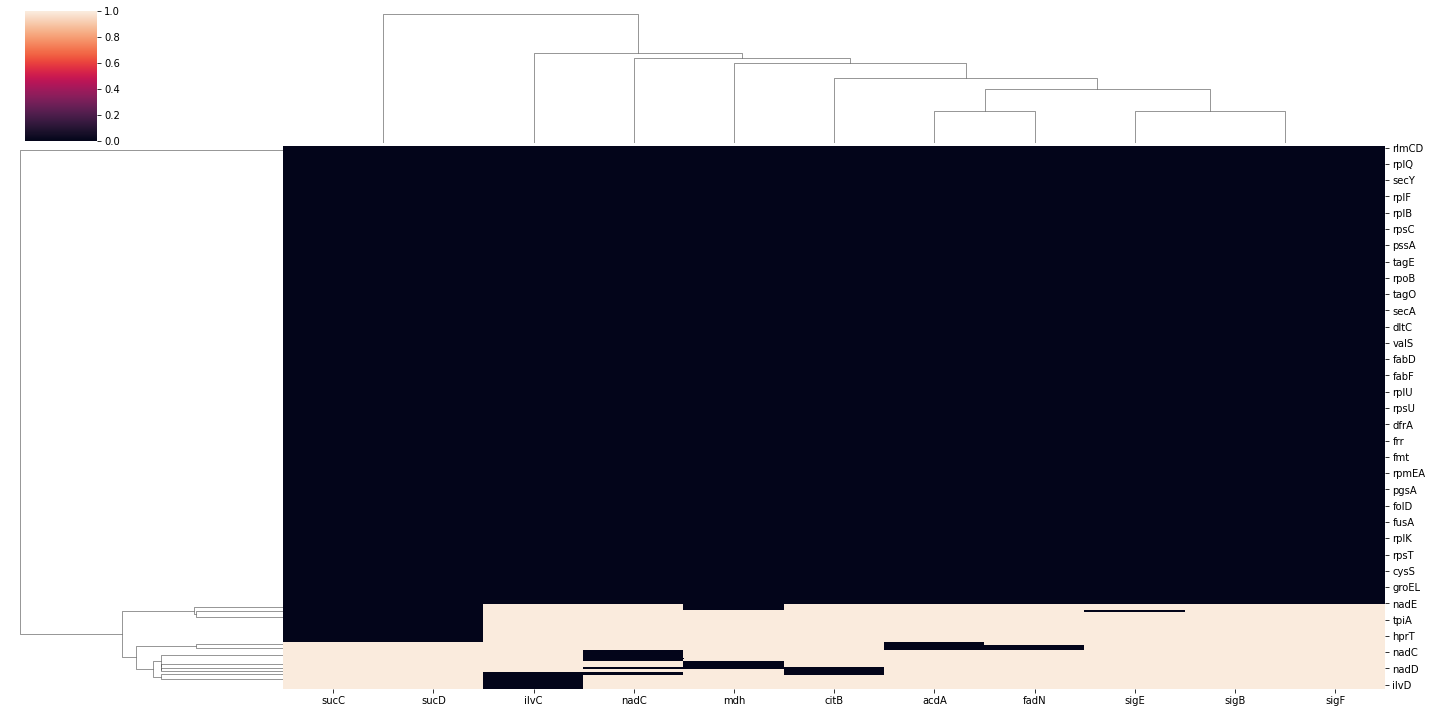

In [330]:
df = expression.loc[depletions_in_model]
induced_inactivation_of_known = df.T.loc[(df==0).any()].T
plt.figure(figsize=(20,10))
sns.clustermap(induced_inactivation_of_known.T>0,
              figsize=(20,10))

<Figure size 1440x720 with 0 Axes>

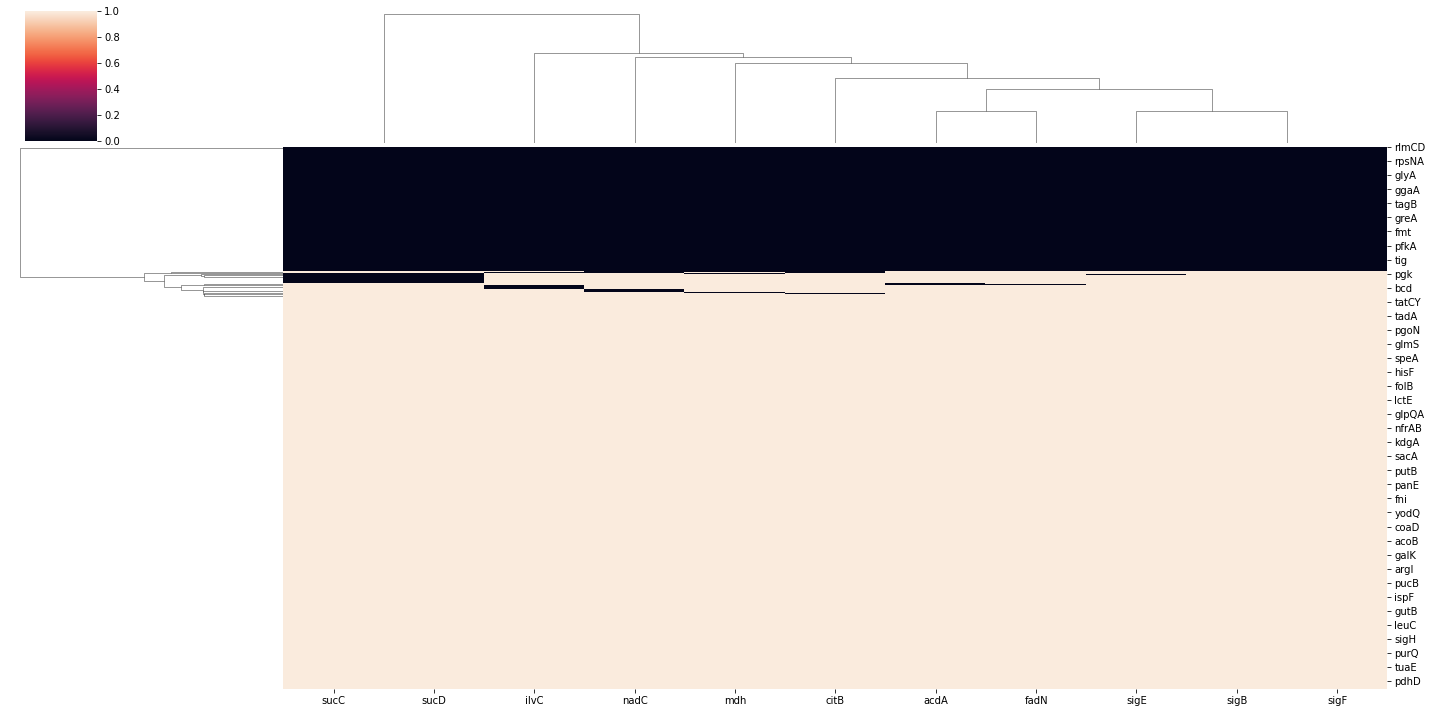

In [331]:
df = expression.loc[depletions_in_model].T
inactivated_by_known = df.T.loc[(df==0).any()].T
plt.figure(figsize=(20,10))
sns.clustermap(inactivated_by_known>0,
              figsize=(20,10))

<AxesSubplot:>

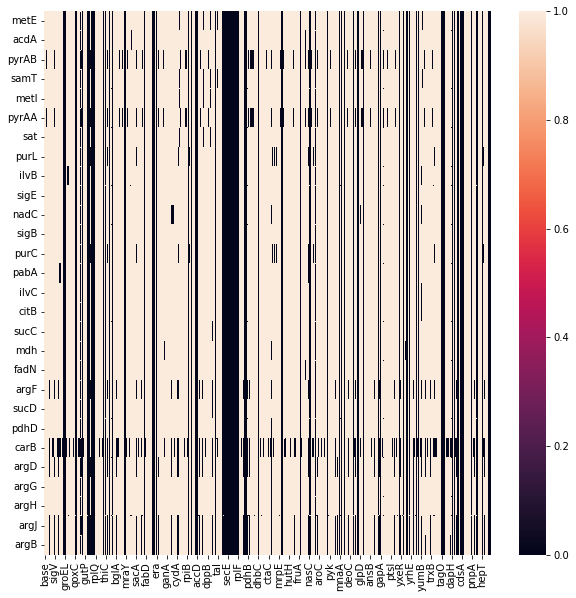

In [247]:
plt.figure(figsize=(10,10))
sns.heatmap((expression>0.)[depletions_in_model])

<AxesSubplot:>

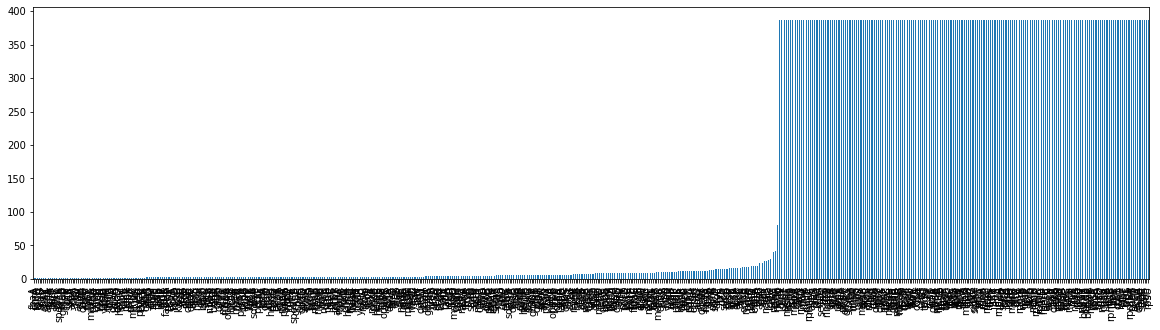

In [234]:
plt.figure(figsize=(20,5))
df = (expression==0.).sum()
df[df>0].sort_values().plot.bar()

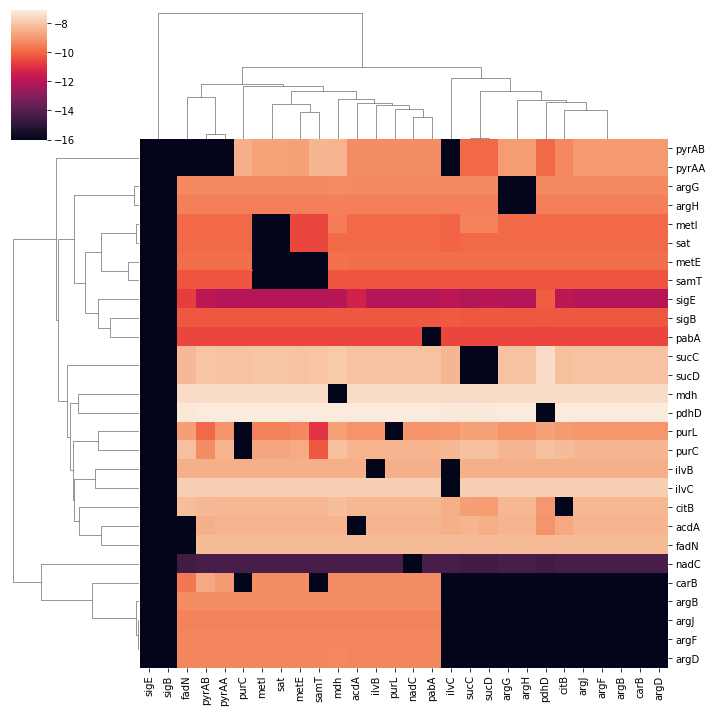

In [140]:
sns.clustermap(log_expression_known,
              figsize=(10,10))

/home/jt/me_modeling/lib/python3.6/site-packages/seaborn/matrix.py:654 UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


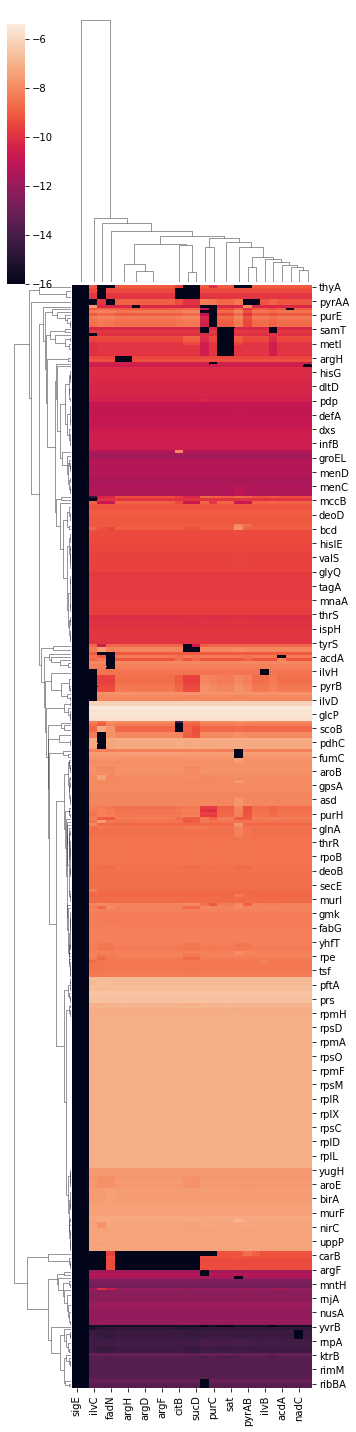

In [141]:
sns.clustermap(log_expression_all,
              figsize=(5,20))